In this notebook, we attempt to fit an ensemble model that combines information from both the structured clinical risk factor data as well as the unstructured Xray images. We proceed to build an iterate on a number of models, using logistic regression and CatBoost as our algorithms of choice, and various combinations of the following as input features: 
- predicted probabilities from the X-ray CNN model (`XrayPred`)
- predicted probabilities from the clinical CatBoost model (`ClinicalPred`)
- as well as the clinical risk factor input features to the CatBoost model 

Note that the `XrayPred` and `ClinicalPred` used to train these ensemble methods were generated out-of-sample using a 4-fold cross validation within the training set. 

In [1]:
# mount our google drive onto colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# set that folder to be our working directory 
import os 
os.chdir("/content/gdrive/My Drive/oai-xray-tkr-klg")

In [3]:
# manually install some dependencies 
!pip install catboost==0.24 shap

     |████████████████████████████████| 65.8 MB 85 kB/s 
     |████████████████████████████████| 564 kB 38.9 MB/s 


In [4]:
import numpy as np 
import pandas as pd
import scipy 
from tkr_methods.modeling import fit_eval_logit, fit_eval_catboost, select_features, \
    cv_catboost, cv_logit, get_eval_metrics

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [5]:
# load train and test predictions from Xray CNN model 
XRAY_CV_TRAIN_PREDS_FP = 'output/cnn_xray_train_cv_probs.csv' 
XRAY_TEST_PREDS_FP = 'output/cnn_xray_test_preds.csv' 

# load train and test predictions from clinical CatBoost model 
CLINICAL_CV_TRAIN_PREDS_FP = 'output/catboost_clinical_train_cv_preds.csv' 
CLINICAL_TEST_PREDS_FP = 'output/catboost_clinical_test_preds.csv' 

# load desc of clinical features to retrieve list of features used in clinical CatBoost model 
SELECTED_FEATURES_DESC_FP = 'output/selected_clinical_variable_desc.csv'

# output final ensemble predictions here  
ENSEMBLE_TEST_PREDS_FP = 'output/final_ensemble_test_preds.csv' 

In [6]:
clinical_preds = pd.read_csv(CLINICAL_CV_TRAIN_PREDS_FP)
clinical_preds.info()
clinical_preds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Columns: 745 entries, V00ILLPWK1 to Fold
dtypes: float64(706), int64(36), object(3)
memory usage: 38.1+ MB


,V00ILLPWK1,P02KPN,P01KPACT30,P01BP30,P01TMJE6M,P01TMJF6M,V00SF1,V00SF2,V00SF3,V00SF4,V00SF5,V00SF6,V00SF7,V00SF8,V00SF9,V00SF10,V00SF11,V00SF12,V00KQOL1,V00KQOL2,V00KQOL3,V00KQOL4,V00KGLRS,P01KPACTCV,P01BPTOT,V00HSPSS,V00HSMSS,V00KOOSQOL,P01SXKOA,P01KPA30CV,P01TJE30CV,P01TJF30CV,P01TJE30WC,P01TJF30WC,P01BPDAYCV,P01BPBEDCV,P01BPACTCV,P01KSX,P01KPACDCV,P02KPMED,...,OtherKnee_KLGrade,BroughtPrescriptionMedsL30D,CalciumTumsIntakeL30D,UsedPainMedEitherKnee,PhysicalActivityScaleElderly,ConsideringKneeReplacement,RxUseRofecoxib,ChickenTurkeyIntakeL12M,UsedNSAIDSEveryOtherDayL30D,BUkXRReadingLateral,FlexionContractureHyperextension,DailyCalciumIntake,KneeDifficultySelfRating,KneeCapTenderness,OtherKnee_BUkXRReadingMedial,UsedPainMedsEveryOtherDayL12M,OtherKnee_FlexionPain,TookPainMedsToday,AbdominalCircumference,HistoryKneeSurgery,OtherKnee_CompositeOAGrade,HoursSitting,RadialPulse,FeltFearfulFrequencyL7D,OtherKnee_MedialJointSpaceNarrowing,IceCreamConsumedEachTime,DoctorDiagnosedOtherArthritis,ChooseLowFatIceCream,CerealIntakeL12M,GeneralHealthSelfRated,OtherKnee_DifficultyStanding,VegetableIntakeL12M,DaidzeinIntake,BMI,Sex,KneeInjury,KneeAlignment,Probability,Prediction,Fold
0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,3.0,3.0,4.0,5.0,4.0,5.0,1.0,3.0,3.0,4.0,5.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,58.00,47.01,68.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1,1.0,1.0,100.0,0.0,0.0,7.0,1.0,2.0,3.0,1130.0,1.0,1.0,0.0,1.0,0.0,1.0,95.4,0.0,0.0,4.0,64.0,1.0,0.0,2.0,0.0,1.0,2.0,2.0,0.0,5.0,0.00,23.0,2,1.0,-5.0,0.156563,0,1
1,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,5.0,5.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,3.0,0.0,0.0,2.0,5.0,0.0,0.0,55.03,44.11,68.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1,1.0,0.0,289.0,0.0,0.0,8.0,0.0,0.0,0.0,1130.0,2.0,0.0,0.0,0.0,1.0,0.0,109.2,0.0,2.0,2.0,75.0,1.0,0.0,2.0,1.0,1.0,5.0,2.0,0.0,8.0,0.00,29.8,2,0.0,5.0,0.028704,0,1
2,0.0,1.0,0.0,1.0,0.0,0.0,2.0,3.0,3.0,4.0,5.0,5.0,5.0,1.0,2.0,2.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54.53,57.73,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1,0.0,1.0,74.0,0.0,0.0,5.0,1.0,0.0,0.0,130.0,0.0,0.0,0.0,1.0,0.0,0.0,109.3,0.0,0.0,3.0,66.0,1.0,0.0,3.0,0.0,3.0,7.0,2.0,0.0,7.0,0.00,29.1,2,0.0,5.0,0.161556,0,1
3,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,3.0,2.0,2.0,5.0,5.0,2.0,2.0,1.0,1.0,3.0,0.0,0.0,46.98,59.32,62.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,4.0,1,1.0,0.0,207.0,0.0,0.0,4.0,0.0,0.0,0.0,807.4,1.0,NaN,3.0,0.0,0.0,0.0,66.0,1.0,4.0,3.0,72.0,1.0,2.0,2.0,1.0,3.0,1.0,3.0,0.0,5.0,1684.56,23.7,2,1.0,0.0,0.083192,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,5.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,56.15,57.16,87.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,1.0,1,1.0,0.0,301.0,0.0,0.0,5.0,0.0,0.0,-4.0,378.7,0.0,0.0,0.0,0.0,0.0,0.0,121.0,0.0,1.0,3.0,74.0,1.0,0.0,2.0,0.0,3.0,5.0,2.0,0.0,7.0,0.00,35.4,2,0.0,0.0,0.009006,0,1


In [8]:
xray_preds = pd.read_csv(XRAY_CV_TRAIN_PREDS_FP) 
xray_preds.info()
xray_preds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6695 non-null   int64  
 1   Filename    6695 non-null   object 
 2   TKR_Prob    6695 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 157.0+ KB


,Unnamed: 0,Filename,TKR_Prob
0,0,9716412_00m_RIGHT_KNEE,0.172508
1,1,9716478_00m_RIGHT_KNEE,0.109933
2,2,9716505_00m_RIGHT_KNEE,0.001348
3,3,9717977_00m_RIGHT_KNEE,0.002936
4,4,9720535_00m_RIGHT_KNEE,0.033606


In [9]:
clinical_test_preds = pd.read_csv(CLINICAL_TEST_PREDS_FP)
clinical_test_preds.info()
clinical_test_preds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Columns: 744 entries, V00ILLPWK1 to Prediction
dtypes: float64(706), int64(35), object(3)
memory usage: 12.7+ MB


,V00ILLPWK1,P02KPN,P01KPACT30,P01BP30,P01TMJE6M,P01TMJF6M,V00SF1,V00SF2,V00SF3,V00SF4,V00SF5,V00SF6,V00SF7,V00SF8,V00SF9,V00SF10,V00SF11,V00SF12,V00KQOL1,V00KQOL2,V00KQOL3,V00KQOL4,V00KGLRS,P01KPACTCV,P01BPTOT,V00HSPSS,V00HSMSS,V00KOOSQOL,P01SXKOA,P01KPA30CV,P01TJE30CV,P01TJF30CV,P01TJE30WC,P01TJF30WC,P01BPDAYCV,P01BPBEDCV,P01BPACTCV,P01KSX,P01KPACDCV,P02KPMED,...,DoctorDiagnosedOA,OtherKnee_KLGrade,BroughtPrescriptionMedsL30D,CalciumTumsIntakeL30D,UsedPainMedEitherKnee,PhysicalActivityScaleElderly,ConsideringKneeReplacement,RxUseRofecoxib,ChickenTurkeyIntakeL12M,UsedNSAIDSEveryOtherDayL30D,BUkXRReadingLateral,FlexionContractureHyperextension,DailyCalciumIntake,KneeDifficultySelfRating,KneeCapTenderness,OtherKnee_BUkXRReadingMedial,UsedPainMedsEveryOtherDayL12M,OtherKnee_FlexionPain,TookPainMedsToday,AbdominalCircumference,HistoryKneeSurgery,OtherKnee_CompositeOAGrade,HoursSitting,RadialPulse,FeltFearfulFrequencyL7D,OtherKnee_MedialJointSpaceNarrowing,IceCreamConsumedEachTime,DoctorDiagnosedOtherArthritis,ChooseLowFatIceCream,CerealIntakeL12M,GeneralHealthSelfRated,OtherKnee_DifficultyStanding,VegetableIntakeL12M,DaidzeinIntake,BMI,Sex,KneeInjury,KneeAlignment,Probability,Prediction
0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,3.0,5.0,4.0,5.0,5.0,2.0,2.0,2.0,4.0,5.0,2.0,3.0,1.0,1.0,1.0,2.0,0.0,52.64,55.76,56.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,...,1.0,2.0,1,1.0,1.0,139.0,0.0,0.0,4.0,0.0,0.0,-4.0,1130.0,1.0,0.0,1.0,1.0,0.0,0.0,104.5,0.0,3.0,3.0,68.0,1.0,1.0,3.0,1.0,1.0,7.0,2.0,0.0,4.0,0.0,30.7,2,0.0,4.0,0.348436,0
1,1.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,2.0,3.0,3.0,5.0,5.0,2.0,2.0,2.0,5.0,5.0,3.0,2.0,0.0,2.0,7.0,2.0,0.0,36.47,64.55,56.3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,0.0,...,1.0,3.0,1,0.0,0.0,36.0,1.0,0.0,5.0,1.0,0.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,111.6,1.0,1.0,2.0,79.0,1.0,1.0,1.0,1.0,2.0,9.0,3.0,0.0,6.0,0.0,29.8,2,1.0,7.0,0.484676,0
2,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,5.0,2.0,5.0,5.0,NaN,1.0,2.0,5.0,NaN,4.0,3.0,3.0,3.0,8.0,2.0,0.0,NaN,NaN,18.8,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,1.0,...,1.0,2.0,1,0.0,1.0,35.0,0.0,0.0,6.0,1.0,0.0,0.0,130.0,3.0,0.0,1.0,0.0,0.0,0.0,116.3,1.0,2.0,4.0,73.0,1.0,0.0,3.0,1.0,2.0,6.0,2.0,2.0,5.0,0.0,33.2,1,0.0,-1.0,0.033512,0
3,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,2.0,2.0,1.0,5.0,5.0,4.0,2.0,2.0,2.0,5.0,0.0,0.0,53.20,60.52,37.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1,1.0,0.0,205.0,0.0,0.0,3.0,0.0,0.0,0.0,1130.0,2.0,0.0,0.0,0.0,0.0,0.0,113.2,0.0,1.0,2.0,80.0,1.0,0.0,2.0,1.0,1.0,6.0,2.0,0.0,3.0,0.0,26.8,2,0.0,0.0,0.428249,0
4,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,2.0,5.0,5.0,5.0,5.0,2.0,2.0,1.0,5.0,5.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,49.56,62.50,62.5,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,1.0,...,1.0,3.0,1,0.0,1.0,204.0,0.0,0.0,6.0,0.0,0.0,8.0,130.0,1.0,0.0,2.0,1.0,1.0,0.0,109.2,1.0,3.0,3.0,79.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,0.0,5.0,0.0,30.9,1,1.0,-2.0,0.119676,0


In [10]:
xray_test_preds = pd.read_csv(XRAY_TEST_PREDS_FP) 
xray_test_preds.info()
xray_test_preds.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2237 non-null   int64  
 1   Filename    2237 non-null   object 
 2   TKR_Prob    2237 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 52.6+ KB


,Unnamed: 0,Filename,TKR_Prob
0,0,9051696_00m_LEFT_KNEE,0.302540
1,1,9051960_00m_LEFT_KNEE,0.298902
2,2,9052978_00m_LEFT_KNEE,0.566001
3,3,9053872_00m_LEFT_KNEE,0.111101
4,4,9054972_00m_LEFT_KNEE,0.108503


In [11]:
clinical_features = pd.read_csv(SELECTED_FEATURES_DESC_FP)
clinical_features.info()
clinical_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Feature                       48 non-null     object
 1   FeatureRenamed                48 non-null     object
 2   Definition                    48 non-null     object
 3   InFinalCatBoost               48 non-null     int64 
 4   Source Feature(s)             48 non-null     object
 5   Source Feature(s) Definition  48 non-null     object
 6   Dataset                       48 non-null     object
 7   AttributeOf                   48 non-null     object
 8   Type                          48 non-null     object
 9   Formula                       15 non-null     object
dtypes: int64(1), object(9)
memory usage: 3.9+ KB


,Feature,FeatureRenamed,Definition,InFinalCatBoost,Source Feature(s),Source Feature(s) Definition,Dataset,AttributeOf,Type,Formula
0,KNEE_V00XRKL,KLGrade,Kellgren and Lawrence (grades 0-4),1,V00XRKL,BL/FU kXR reading (BU): Kellgren and Lawrence ...,kXR_SQ_BU00,Knee,Original,NaN
1,KNEE_V00XRJSM,BUkXRReading,Joint space narrowing (OARSI grades 0-3) media...,1,V00XRJSM,BL/FU kXR reading (BU): joint space narrowing ...,kXR_SQ_BU00,Knee,Original,NaN
2,KNEE_P01LXRKOA2,Osteophytes&JSN,Knee baseline x-ray: osteophytes and JSN,1,"P01LXRKOA2, P01RXRKOA",SV:Left (Right) knee baseline x-ray: osteophyt...,SubjectChar00,Knee,Derived (knee-matching),"P01LXRKOA2 if SIDE=""LEFT"" else P01RXRKOA"
3,KNEE_P01OAGRDL,CompositeOAGrade,Knee baseline x-ray: composite OA grade,1,"P01OAGRDL, P01OAGRDR",SV:Left (Right) knee baseline x-ray: composite...,SubjectChar00,Knee,Derived (knee-matching),"P01OAGRDL if SIDE=""LEFT"" else P01OAGRDR"
4,KNEE_V00LKRFXPN,FlexionPain,Knee flexion pain/tenderness present on exam,1,"V00LKRFXPN, V00RKRFXPN",EV:Left (Right) knee exam: knee flexion pain/t...,PhysExam00,Knee,Derived (knee-matching),"V00LKRFXPN if SIDE=""LEFT"" else V00RKRFXPN"


In [13]:
selected_clinical_features = clinical_features.query("InFinalCatBoost==1")['FeatureRenamed'].tolist()
print(selected_clinical_features)

['KLGrade', 'BUkXRReading', 'Osteophytes&JSN', 'CompositeOAGrade', 'FlexionPain', 'RaceIsBlack', 'AwarenessKneeProblems', 'UsedPainMedsL12M', 'Age', 'KneeCatchHangUpL7D', 'DoctorDiagnosedOA', 'OtherKnee_KLGrade', 'BroughtPrescriptionMedsL30D', 'CalciumTumsIntakeL30D', 'UsedPainMedEitherKnee', 'PhysicalActivityScaleElderly', 'ConsideringKneeReplacement', 'RxUseRofecoxib', 'ChickenTurkeyIntakeL12M', 'UsedNSAIDSEveryOtherDayL30D', 'BUkXRReadingLateral', 'FlexionContractureHyperextension', 'DailyCalciumIntake', 'KneeDifficultySelfRating', 'KneeCapTenderness', 'OtherKnee_BUkXRReadingMedial', 'UsedPainMedsEveryOtherDayL12M', 'OtherKnee_FlexionPain', 'TookPainMedsToday', 'AbdominalCircumference', 'HistoryKneeSurgery', 'OtherKnee_CompositeOAGrade', 'HoursSitting', 'RadialPulse', 'FeltFearfulFrequencyL7D', 'OtherKnee_MedialJointSpaceNarrowing', 'IceCreamConsumedEachTime', 'DoctorDiagnosedOtherArthritis', 'ChooseLowFatIceCream', 'CerealIntakeL12M', 'GeneralHealthSelfRated', 'OtherKnee_Difficulty

# Process Data

In [14]:
def merge_preds(clinical_preds, xray_preds):
    """ Merge X-ray model predictions onto Clinical model predictions (and input features) into a single df """
    xray_preds['Knee_ID'] = xray_preds['Filename'].str.replace('00m_','').str.replace('_KNEE','')
    xray_preds_series = xray_preds.set_index('Knee_ID')['TKR_Prob']
    df = clinical_preds.merge(xray_preds_series, how='left', left_on='Knee_ID', right_index=True)
    df = df.rename(columns={'Probability': 'ClinicalPred', 'TKR_Prob': 'XrayPred'})
    df['ClinicalPredLogit'] = scipy.special.logit(df['ClinicalPred'])
    df['XrayPredLogit'] = scipy.special.logit(df['XrayPred'])

    return df 

In [15]:
# merge train xray preds onto train clinical preds (and input features)
df = merge_preds(clinical_preds, xray_preds)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Columns: 748 entries, V00ILLPWK1 to XrayPredLogit
dtypes: float64(709), int64(36), object(3)
memory usage: 38.2+ MB


,V00ILLPWK1,P02KPN,P01KPACT30,P01BP30,P01TMJE6M,P01TMJF6M,V00SF1,V00SF2,V00SF3,V00SF4,V00SF5,V00SF6,V00SF7,V00SF8,V00SF9,V00SF10,V00SF11,V00SF12,V00KQOL1,V00KQOL2,V00KQOL3,V00KQOL4,V00KGLRS,P01KPACTCV,P01BPTOT,V00HSPSS,V00HSMSS,V00KOOSQOL,P01SXKOA,P01KPA30CV,P01TJE30CV,P01TJF30CV,P01TJE30WC,P01TJF30WC,P01BPDAYCV,P01BPBEDCV,P01BPACTCV,P01KSX,P01KPACDCV,P02KPMED,...,UsedPainMedEitherKnee,PhysicalActivityScaleElderly,ConsideringKneeReplacement,RxUseRofecoxib,ChickenTurkeyIntakeL12M,UsedNSAIDSEveryOtherDayL30D,BUkXRReadingLateral,FlexionContractureHyperextension,DailyCalciumIntake,KneeDifficultySelfRating,KneeCapTenderness,OtherKnee_BUkXRReadingMedial,UsedPainMedsEveryOtherDayL12M,OtherKnee_FlexionPain,TookPainMedsToday,AbdominalCircumference,HistoryKneeSurgery,OtherKnee_CompositeOAGrade,HoursSitting,RadialPulse,FeltFearfulFrequencyL7D,OtherKnee_MedialJointSpaceNarrowing,IceCreamConsumedEachTime,DoctorDiagnosedOtherArthritis,ChooseLowFatIceCream,CerealIntakeL12M,GeneralHealthSelfRated,OtherKnee_DifficultyStanding,VegetableIntakeL12M,DaidzeinIntake,BMI,Sex,KneeInjury,KneeAlignment,ClinicalPred,Prediction,Fold,XrayPred,ClinicalPredLogit,XrayPredLogit
0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,3.0,3.0,4.0,5.0,4.0,5.0,1.0,3.0,3.0,4.0,5.0,3.0,0.0,1.0,1.0,2.0,0.0,0.0,58.00,47.01,68.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,100.0,0.0,0.0,7.0,1.0,2.0,3.0,1130.0,1.0,1.0,0.0,1.0,0.0,1.0,95.4,0.0,0.0,4.0,64.0,1.0,0.0,2.0,0.0,1.0,2.0,2.0,0.0,5.0,0.00,23.0,2,1.0,-5.0,0.156563,0,1,0.324141,-1.684023,-0.734806
1,1.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,5.0,5.0,3.0,3.0,3.0,2.0,3.0,4.0,5.0,3.0,0.0,0.0,2.0,5.0,0.0,0.0,55.03,44.11,68.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,289.0,0.0,0.0,8.0,0.0,0.0,0.0,1130.0,2.0,0.0,0.0,0.0,1.0,0.0,109.2,0.0,2.0,2.0,75.0,1.0,0.0,2.0,1.0,1.0,5.0,2.0,0.0,8.0,0.00,29.8,2,0.0,5.0,0.028704,0,1,0.046076,-3.521606,-3.030299
2,0.0,1.0,0.0,1.0,0.0,0.0,2.0,3.0,3.0,4.0,5.0,5.0,5.0,1.0,2.0,2.0,5.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,54.53,57.73,93.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,74.0,0.0,0.0,5.0,1.0,0.0,0.0,130.0,0.0,0.0,0.0,1.0,0.0,0.0,109.3,0.0,0.0,3.0,66.0,1.0,0.0,3.0,0.0,3.0,7.0,2.0,0.0,7.0,0.00,29.1,2,0.0,5.0,0.161556,0,1,0.056381,-1.646694,-2.817597
3,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,5.0,5.0,5.0,5.0,3.0,2.0,2.0,5.0,5.0,2.0,2.0,1.0,1.0,3.0,0.0,0.0,46.98,59.32,62.5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,207.0,0.0,0.0,4.0,0.0,0.0,0.0,807.4,1.0,NaN,3.0,0.0,0.0,0.0,66.0,1.0,4.0,3.0,72.0,1.0,2.0,2.0,1.0,3.0,1.0,3.0,0.0,5.0,1684.56,23.7,2,1.0,0.0,0.083192,0,1,0.037950,-2.399744,-3.232794
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,1.0,2.0,2.0,5.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,56.15,57.16,87.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,301.0,0.0,0.0,5.0,0.0,0.0,-4.0,378.7,0.0,0.0,0.0,0.0,0.0,0.0,121.0,0.0,1.0,3.0,74.0,1.0,0.0,2.0,0.0,3.0,5.0,2.0,0.0,7.0,0.00,35.4,2,0.0,0.0,0.009006,0,1,0.015008,-4.700769,-4.184045


In [16]:
# merge test xray preds onto test clinical preds (and input features)
test_df = merge_preds(clinical_test_preds, xray_test_preds)
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Columns: 747 entries, V00ILLPWK1 to XrayPredLogit
dtypes: float64(709), int64(35), object(3)
memory usage: 12.7+ MB


,V00ILLPWK1,P02KPN,P01KPACT30,P01BP30,P01TMJE6M,P01TMJF6M,V00SF1,V00SF2,V00SF3,V00SF4,V00SF5,V00SF6,V00SF7,V00SF8,V00SF9,V00SF10,V00SF11,V00SF12,V00KQOL1,V00KQOL2,V00KQOL3,V00KQOL4,V00KGLRS,P01KPACTCV,P01BPTOT,V00HSPSS,V00HSMSS,V00KOOSQOL,P01SXKOA,P01KPA30CV,P01TJE30CV,P01TJF30CV,P01TJE30WC,P01TJF30WC,P01BPDAYCV,P01BPBEDCV,P01BPACTCV,P01KSX,P01KPACDCV,P02KPMED,...,CalciumTumsIntakeL30D,UsedPainMedEitherKnee,PhysicalActivityScaleElderly,ConsideringKneeReplacement,RxUseRofecoxib,ChickenTurkeyIntakeL12M,UsedNSAIDSEveryOtherDayL30D,BUkXRReadingLateral,FlexionContractureHyperextension,DailyCalciumIntake,KneeDifficultySelfRating,KneeCapTenderness,OtherKnee_BUkXRReadingMedial,UsedPainMedsEveryOtherDayL12M,OtherKnee_FlexionPain,TookPainMedsToday,AbdominalCircumference,HistoryKneeSurgery,OtherKnee_CompositeOAGrade,HoursSitting,RadialPulse,FeltFearfulFrequencyL7D,OtherKnee_MedialJointSpaceNarrowing,IceCreamConsumedEachTime,DoctorDiagnosedOtherArthritis,ChooseLowFatIceCream,CerealIntakeL12M,GeneralHealthSelfRated,OtherKnee_DifficultyStanding,VegetableIntakeL12M,DaidzeinIntake,BMI,Sex,KneeInjury,KneeAlignment,ClinicalPred,Prediction,XrayPred,ClinicalPredLogit,XrayPredLogit
0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,3.0,5.0,4.0,5.0,5.0,2.0,2.0,2.0,4.0,5.0,2.0,3.0,1.0,1.0,1.0,2.0,0.0,52.64,55.76,56.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,1.0,...,1.0,1.0,139.0,0.0,0.0,4.0,0.0,0.0,-4.0,1130.0,1.0,0.0,1.0,1.0,0.0,0.0,104.5,0.0,3.0,3.0,68.0,1.0,1.0,3.0,1.0,1.0,7.0,2.0,0.0,4.0,0.0,30.7,2,0.0,4.0,0.348436,0,0.529985,-0.625921,0.120083
1,1.0,1.0,1.0,0.0,0.0,0.0,3.0,2.0,2.0,3.0,3.0,5.0,5.0,2.0,2.0,2.0,5.0,5.0,3.0,2.0,0.0,2.0,7.0,2.0,0.0,36.47,64.55,56.3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,0.0,...,0.0,0.0,36.0,1.0,0.0,5.0,1.0,0.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,111.6,1.0,1.0,2.0,79.0,1.0,1.0,1.0,1.0,2.0,9.0,3.0,0.0,6.0,0.0,29.8,2,1.0,7.0,0.484676,0,0.377360,-0.061317,-0.500771
2,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,5.0,2.0,5.0,5.0,NaN,1.0,2.0,5.0,NaN,4.0,3.0,3.0,3.0,8.0,2.0,0.0,NaN,NaN,18.8,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0,1.0,...,0.0,1.0,35.0,0.0,0.0,6.0,1.0,0.0,0.0,130.0,3.0,0.0,1.0,0.0,0.0,0.0,116.3,1.0,2.0,4.0,73.0,1.0,0.0,3.0,1.0,2.0,6.0,2.0,2.0,5.0,0.0,33.2,1,0.0,-1.0,0.033512,0,0.110282,-3.361772,-2.087866
3,0.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,2.0,2.0,1.0,5.0,5.0,4.0,2.0,2.0,2.0,5.0,0.0,0.0,53.20,60.52,37.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,1.0,0.0,205.0,0.0,0.0,3.0,0.0,0.0,0.0,1130.0,2.0,0.0,0.0,0.0,0.0,0.0,113.2,0.0,1.0,2.0,80.0,1.0,0.0,2.0,1.0,1.0,6.0,2.0,0.0,3.0,0.0,26.8,2,0.0,0.0,0.428249,0,0.317108,-0.288998,-0.767092
4,0.0,1.0,1.0,1.0,0.0,0.0,2.0,3.0,2.0,5.0,5.0,5.0,5.0,2.0,2.0,1.0,5.0,5.0,2.0,2.0,1.0,1.0,2.0,2.0,0.0,49.56,62.50,62.5,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,1.0,...,0.0,1.0,204.0,0.0,0.0,6.0,0.0,0.0,8.0,130.0,1.0,0.0,2.0,1.0,1.0,0.0,109.2,1.0,3.0,3.0,79.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,0.0,5.0,0.0,30.9,1,1.0,-2.0,0.119676,0,0.190368,-1.995499,-1.447619


# Train Models

For each ensembling methods, we first: 
- Fit a single model using a fixed train/val set (using fold 1 as val, folds 2-4 as train) and inspect its coefficients, shap values etc. 
- And then run a full 4-fold cross validation to generalize its performance as a better estimate of test performance

In [17]:
train = df.query("Fold!=1")
val = df.query("Fold==1")
print(f"train: {len(train)}, val: {len(val)}")

train: 5035, val: 1660


### Model 1: Logistic Regression with only `ClinicalPred` and `XrayPred` as input features 

In [18]:
logit, preds, metrics = fit_eval_logit(cat_features=[], num_features=['ClinicalPred', 'XrayPred'], 
                                       other_formula=None, train=train, val=val, label='KR_LABEL')

Optimization terminated successfully.
         Current function value: 0.147692
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 5035
Model:                          Logit   Df Residuals:                     5032
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.3553
Time:                        02:41:43   Log-Likelihood:                -743.63
converged:                       True   LL-Null:                       -1153.5
Covariance Type:            nonrobust   LLR p-value:                1.002e-178
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.4314      0.118    -37.518      0.000      -4.663      -4.200
ClinicalPred     9.5878      0.483     19.837      0.000       8.640      10.535
XrayPred         6.2399      0.411     15.190      0.000       5.435       7.045
================================================================================
"""

{'logloss': 0.1649, 'accuracy': 0.944, 'balanced_accuracy': 0.66, 'auroc': 0.8856, 'auprc': 0.4734}


In [19]:
logit_cv_preds = cv_logit(df=df, cat_features=[], num_features=['ClinicalPred', 'XrayPred'], other_formula=None)
metrics_logit = get_eval_metrics(y_true=logit_cv_preds['KR_LABEL'], y_pred=logit_cv_preds['Prediction'])
print(f"CV metrics: {metrics_logit}")

Optimization terminated successfully.
         Current function value: 0.147692
         Iterations 8
{'logloss': 0.1649, 'accuracy': 0.944, 'balanced_accuracy': 0.66, 'auroc': 0.8856, 'auprc': 0.4734}
Optimization terminated successfully.
         Current function value: 0.144067
         Iterations 8
{'logloss': 0.1789, 'accuracy': 0.9369, 'balanced_accuracy': 0.6546, 'auroc': 0.8895, 'auprc': 0.4391}
Optimization terminated successfully.
         Current function value: 0.155431
         Iterations 8
{'logloss': 0.1414, 'accuracy': 0.9505, 'balanced_accuracy': 0.6344, 'auroc': 0.9229, 'auprc': 0.5939}
Optimization terminated successfully.
         Current function value: 0.158088
         Iterations 8
{'logloss': 0.135, 'accuracy': 0.9523, 'balanced_accuracy': 0.6445, 'auroc': 0.9496, 'auprc': 0.6476}
CV metrics: {'logloss': 0.155, 'accuracy': 0.9459, 'balanced_accuracy': 0.6484, 'auroc': 0.8944, 'auprc': 0.5002}


In [20]:
# check correlation between the predictions 
df[['ClinicalPred', 'XrayPred']].corr()

,ClinicalPred,XrayPred
ClinicalPred,1.000000,0.184689
XrayPred,0.184689,1.000000


### Model 2: Logistic Regression with only `ClinicalPredLogit` and `XrayPredLogit` as input features 

A variant of Model 1, except using the logits of predicted probabilities rather than the predicted probabilities themselves. 

In [21]:
logit, preds, metrics = fit_eval_logit(cat_features=[], num_features=['ClinicalPredLogit', 'XrayPredLogit'], 
                                       other_formula=None, train=train, val=val, label='KR_LABEL')

Optimization terminated successfully.
         Current function value: 0.133711
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 5035
Model:                          Logit   Df Residuals:                     5032
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.4163
Time:                        02:41:55   Log-Likelihood:                -673.23
converged:                       True   LL-Null:                       -1153.5
Covariance Type:            nonrobust   LLR p-value:                2.688e-209
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.5805      0.206     12.519      0.000       2.176       2.984
ClinicalPredLogit     1.1672      0.058     20.126      0.000       1.054       1.281
XrayPredLogit         0.7820      0.054     14.475      0.000       0.676       0.888
=====================================================================================
"""

{'logloss': 0.1469, 'accuracy': 0.9512, 'balanced_accuracy': 0.6777, 'auroc': 0.9063, 'auprc': 0.5257}


In [22]:
logit_cv_pred_logits = cv_logit(df=df, cat_features=[], num_features=['ClinicalPredLogit', 'XrayPredLogit'], other_formula=None)
metrics_logit_logits = get_eval_metrics(y_true=logit_cv_pred_logits['KR_LABEL'], y_pred=logit_cv_pred_logits['Prediction'])
print(f"CV metrics: {metrics_logit_logits}")

Optimization terminated successfully.
         Current function value: 0.133711
         Iterations 9
{'logloss': 0.1469, 'accuracy': 0.9512, 'balanced_accuracy': 0.6777, 'auroc': 0.9063, 'auprc': 0.5257}
Optimization terminated successfully.
         Current function value: 0.131357
         Iterations 9
{'logloss': 0.1563, 'accuracy': 0.9518, 'balanced_accuracy': 0.6625, 'auroc': 0.9027, 'auprc': 0.5278}
Optimization terminated successfully.
         Current function value: 0.139499
         Iterations 9
{'logloss': 0.13, 'accuracy': 0.9553, 'balanced_accuracy': 0.669, 'auroc': 0.9257, 'auprc': 0.6509}
Optimization terminated successfully.
         Current function value: 0.140433
         Iterations 8
{'logloss': 0.131, 'accuracy': 0.9559, 'balanced_accuracy': 0.706, 'auroc': 0.948, 'auprc': 0.688}
CV metrics: {'logloss': 0.1411, 'accuracy': 0.9535, 'balanced_accuracy': 0.6788, 'auroc': 0.9011, 'auprc': 0.5708}


### Model 3: CatBoost with only `ClinicalPred` and `XrayPred` as input features 

Learning rate set to 0.047239
0:	learn: 0.6082196	test: 0.6124076	best: 0.6124076 (0)	total: 51.1ms	remaining: 51.1s
10:	learn: 0.2407547	test: 0.2625275	best: 0.2625275 (10)	total: 77.3ms	remaining: 6.95s
20:	learn: 0.1591729	test: 0.1822084	best: 0.1822084 (20)	total: 104ms	remaining: 4.83s
30:	learn: 0.1379480	test: 0.1613148	best: 0.1613148 (30)	total: 131ms	remaining: 4.1s
40:	learn: 0.1308904	test: 0.1555283	best: 0.1555283 (40)	total: 158ms	remaining: 3.69s
50:	learn: 0.1274478	test: 0.1539379	best: 0.1539379 (50)	total: 188ms	remaining: 3.5s
60:	learn: 0.1251232	test: 0.1539396	best: 0.1537715 (56)	total: 221ms	remaining: 3.4s
70:	learn: 0.1235853	test: 0.1538660	best: 0.1537715 (56)	total: 250ms	remaining: 3.27s
80:	learn: 0.1220817	test: 0.1552268	best: 0.1537715 (56)	total: 277ms	remaining: 3.14s
90:	learn: 0.1208823	test: 0.1556506	best: 0.1537715 (56)	total: 304ms	remaining: 3.04s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.1537715042
bestIteration 

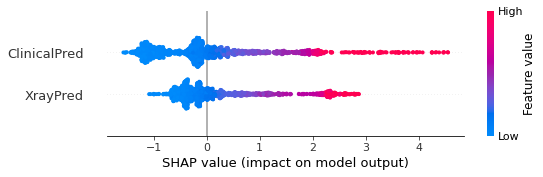

,Feature Id,LossFuncChgImportance,ShapImportance
0,ClinicalPred,0.047770,0.842548
1,XrayPred,0.017663,0.607094


{'logloss': 0.1538, 'accuracy': 0.9446, 'balanced_accuracy': 0.6788, 'auroc': 0.9002, 'auprc': 0.4989}


In [23]:
cb_preds, cb_model, cb_full_shap, cb_importances, cb_metrics = fit_eval_catboost(
    cat_features=[], 
    num_features=['ClinicalPred', 'XrayPred'], 
    train_df=train, val_df=val,
    plot_training=False, plot_shap=True, display_importances=True)

In [24]:
catboost_simple_cv_preds, _ = cv_catboost(cat_features=[], 
    num_features=['ClinicalPred', 'XrayPred'], 
    df=df, label='KR_LABEL', verbose=False, 
    learning_rate=None, iterations=None)
metrics_catboost_simple = get_eval_metrics(y_true=catboost_simple_cv_preds['KR_LABEL'], y_pred=catboost_simple_cv_preds['Probability'])
print(f"CV metrics: {metrics_catboost_simple}")

CV metrics: {'logloss': 0.1443, 'accuracy': 0.9521, 'balanced_accuracy': 0.6757, 'auroc': 0.8979, 'auprc': 0.5445}


### Model 4: CatBoost with `XrayPred` and all clinical risk features (but not `ClinicalPred`)

Learning rate set to 0.047239
0:	learn: 0.6105327	test: 0.6150296	best: 0.6150296 (0)	total: 5.01ms	remaining: 5.01s
10:	learn: 0.2508862	test: 0.2706766	best: 0.2706766 (10)	total: 49.3ms	remaining: 4.43s
20:	learn: 0.1633660	test: 0.1876776	best: 0.1876776 (20)	total: 94ms	remaining: 4.38s
30:	learn: 0.1346352	test: 0.1643284	best: 0.1643284 (30)	total: 141ms	remaining: 4.41s
40:	learn: 0.1222265	test: 0.1566053	best: 0.1566053 (40)	total: 191ms	remaining: 4.47s
50:	learn: 0.1140306	test: 0.1522277	best: 0.1522277 (50)	total: 235ms	remaining: 4.37s
60:	learn: 0.1068981	test: 0.1507978	best: 0.1506812 (59)	total: 279ms	remaining: 4.29s
70:	learn: 0.1004932	test: 0.1491869	best: 0.1491575 (69)	total: 327ms	remaining: 4.27s
80:	learn: 0.0963710	test: 0.1494120	best: 0.1489887 (74)	total: 379ms	remaining: 4.3s
90:	learn: 0.0925551	test: 0.1493131	best: 0.1489084 (88)	total: 423ms	remaining: 4.22s
100:	learn: 0.0887036	test: 0.1490866	best: 0.1489084 (88)	total: 473ms	remaining: 4.21s
110

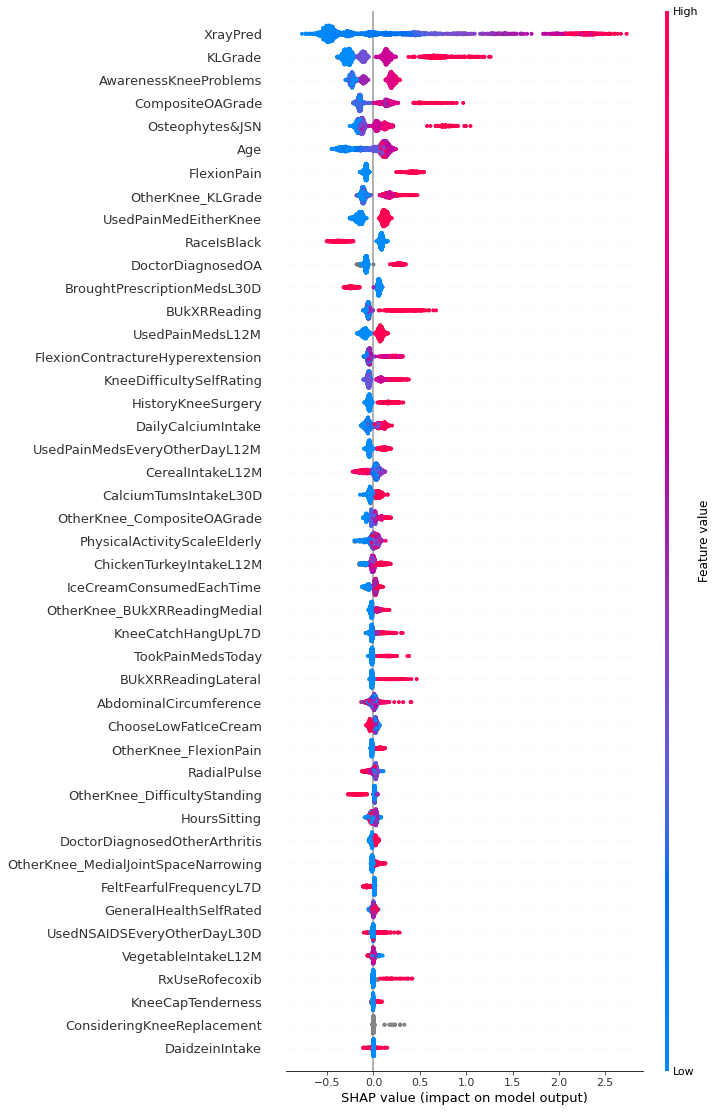

,Feature Id,LossFuncChgImportance,ShapImportance
0,XrayPred,0.022556,0.655653
1,KLGrade,0.004432,0.285134
2,RaceIsBlack,0.001257,0.134281
3,DailyCalciumIntake,0.000855,0.070609
4,DoctorDiagnosedOA,0.000758,0.121320
5,Age,0.000710,0.148310
6,UsedPainMedsEveryOtherDayL12M,0.000607,0.064102
7,AwarenessKneeProblems,0.000589,0.194404
8,BUkXRReading,0.000576,0.088227
9,CalciumTumsIntakeL30D,0.000387,0.042833


{'logloss': 0.1489, 'accuracy': 0.947, 'balanced_accuracy': 0.6616, 'auroc': 0.8996, 'auprc': 0.5171}


In [25]:
cb_preds, cb_model, cb_full_shap, cb_importances, cb_metrics = fit_eval_catboost(
    cat_features=[], 
    num_features= selected_clinical_features + ['XrayPred'], 
    train_df=train, val_df=val,
    plot_training=False, plot_shap=True, display_importances=True)

In [26]:
catboost_full_with_xray_cv_preds, _ = cv_catboost(cat_features=[], 
    num_features=selected_clinical_features + ['XrayPred'],
    df=df, label='KR_LABEL', verbose=False, 
    learning_rate=None, iterations=None)
metrics_catboost_full_with_xray = get_eval_metrics(
    y_true=catboost_full_with_xray_cv_preds['KR_LABEL'], y_pred=catboost_full_with_xray_cv_preds['Probability'])
print(f"CV metrics: {metrics_catboost_full_with_xray}")

CV metrics: {'logloss': 0.1395, 'accuracy': 0.9524, 'balanced_accuracy': 0.6587, 'auroc': 0.9091, 'auprc': 0.5643}


### Model 5: CatBoost with `XrayPred`, `ClinicalPred`, and all clinical risk features

Learning rate set to 0.047239
0:	learn: 0.6077980	test: 0.6133244	best: 0.6133244 (0)	total: 5.13ms	remaining: 5.12s
10:	learn: 0.2514707	test: 0.2699070	best: 0.2699070 (10)	total: 51.9ms	remaining: 4.67s
20:	learn: 0.1619238	test: 0.1861498	best: 0.1861498 (20)	total: 99.4ms	remaining: 4.63s
30:	learn: 0.1339745	test: 0.1631892	best: 0.1631892 (30)	total: 154ms	remaining: 4.82s
40:	learn: 0.1218332	test: 0.1557214	best: 0.1557214 (40)	total: 201ms	remaining: 4.71s
50:	learn: 0.1123073	test: 0.1532609	best: 0.1532609 (50)	total: 249ms	remaining: 4.64s
60:	learn: 0.1069538	test: 0.1516683	best: 0.1516683 (60)	total: 296ms	remaining: 4.55s
70:	learn: 0.1014174	test: 0.1510905	best: 0.1510905 (70)	total: 351ms	remaining: 4.6s
80:	learn: 0.0968935	test: 0.1515715	best: 0.1510905 (70)	total: 404ms	remaining: 4.59s
90:	learn: 0.0933358	test: 0.1517952	best: 0.1510905 (70)	total: 462ms	remaining: 4.61s
100:	learn: 0.0898326	test: 0.1517744	best: 0.1510905 (70)	total: 515ms	remaining: 4.58s
1

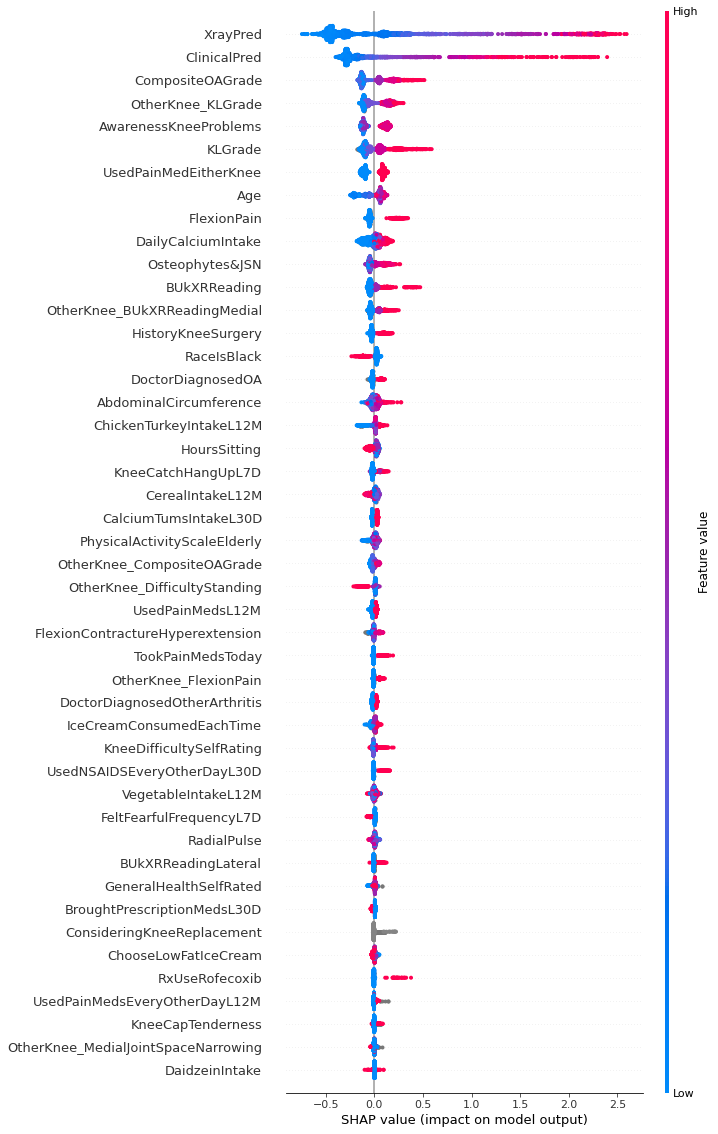

,Feature Id,LossFuncChgImportance,ShapImportance
0,XrayPred,0.021610,0.620606
1,ClinicalPred,0.013613,0.379189
2,Age,0.000517,0.088834
3,DailyCalciumIntake,0.000484,0.063117
4,ConsideringKneeReplacement,0.000474,0.009073
5,ChickenTurkeyIntakeL12M,0.000315,0.030648
6,DoctorDiagnosedOA,0.000262,0.031838
7,RaceIsBlack,0.000218,0.040347
8,OtherKnee_MedialJointSpaceNarrowing,0.000198,0.005558
9,OtherKnee_FlexionPain,0.000177,0.018057


{'logloss': 0.1511, 'accuracy': 0.9476, 'balanced_accuracy': 0.6573, 'auroc': 0.8993, 'auprc': 0.5052}


In [27]:
cb_preds, cb_model, cb_full_shap, cb_importances, cb_metrics = fit_eval_catboost(
    cat_features=[], 
    num_features= selected_clinical_features + ['XrayPred', 'ClinicalPred'], 
    train_df=train, val_df=val,
    plot_training=False, plot_shap=True, display_importances=True)

In [28]:
catboost_full_with_both_cv_preds, _ = cv_catboost(cat_features=[], 
    num_features=selected_clinical_features + ['XrayPred', 'ClinicalPred'], 
    df=df, label='KR_LABEL', verbose=False, 
    learning_rate=None, iterations=None)
metrics_catboost_full_with_both = get_eval_metrics(
    y_true=catboost_full_with_both_cv_preds['KR_LABEL'], y_pred=catboost_full_with_both_cv_preds['Probability'])
print(f"CV metrics: {metrics_catboost_full_with_both}")

CV metrics: {'logloss': 0.1438, 'accuracy': 0.9524, 'balanced_accuracy': 0.6598, 'auroc': 0.8989, 'auprc': 0.5437}


### Model 6: CatBoost with a subset of {`XrayPred`, `ClinicalPred`, and all clinical risk features} 

Here we use a similar process as we did in `Clinical-Modeling.ipynb` to select only a subset of features from `XrayPred`, `ClinicalPred`, and all clinical risk features. We do this by iteratively fitting CatBoost models, dropping features with negative `LossFunctionChange` feature importances. We then use the final features remaining as input features for this model. 

In [29]:
selected_features = select_features(
    full_features=selected_clinical_features + ['ClinicalPred','XrayPred'], 
    train=train, val=val, max_iter=100, eval_metric='auprc')

Iteration 1
{'logloss': 0.1492, 'accuracy': 0.947, 'balanced_accuracy': 0.6662, 'auroc': 0.9031, 'auprc': 0.5178}
Using 46 features, we obtain val loss of 0.14917794917383653
16 features have negative importances and may be dropped in next iter: ['KLGrade', 'BUkXRReading', 'Osteophytes&JSN', 'CompositeOAGrade', 'FlexionPain', 'OtherKnee_KLGrade', 'UsedPainMedEitherKnee', 'PhysicalActivityScaleElderly', 'FlexionContractureHyperextension', 'KneeDifficultySelfRating', 'OtherKnee_BUkXRReadingMedial', 'TookPainMedsToday', 'OtherKnee_CompositeOAGrade', 'IceCreamConsumedEachTime', 'OtherKnee_DifficultyStanding', 'VegetableIntakeL12M']

Iteration 2
{'logloss': 0.1472, 'accuracy': 0.9494, 'balanced_accuracy': 0.6768, 'auroc': 0.9041, 'auprc': 0.5214}
Using 30 features, we obtain val loss of 0.14722436878257306
9 features have negative importances and may be dropped in next iter: ['DoctorDiagnosedOA', 'UsedNSAIDSEveryOtherDayL30D', 'GeneralHealthSelfRated', 'BroughtPrescriptionMedsL30D', 'UsedPa

Learning rate set to 0.047239
0:	learn: 0.6103489	test: 0.6142736	best: 0.6142736 (0)	total: 4.56ms	remaining: 4.55s
10:	learn: 0.2572914	test: 0.2713472	best: 0.2713472 (10)	total: 39.2ms	remaining: 3.52s
20:	learn: 0.1654327	test: 0.1857199	best: 0.1857199 (20)	total: 74.7ms	remaining: 3.48s
30:	learn: 0.1364080	test: 0.1605920	best: 0.1605920 (30)	total: 114ms	remaining: 3.58s
40:	learn: 0.1243033	test: 0.1522666	best: 0.1522666 (40)	total: 157ms	remaining: 3.66s
50:	learn: 0.1168585	test: 0.1487869	best: 0.1487869 (50)	total: 193ms	remaining: 3.59s
60:	learn: 0.1116316	test: 0.1469288	best: 0.1469288 (60)	total: 230ms	remaining: 3.54s
70:	learn: 0.1076937	test: 0.1465345	best: 0.1465035 (69)	total: 266ms	remaining: 3.48s
80:	learn: 0.1033869	test: 0.1464039	best: 0.1464039 (80)	total: 308ms	remaining: 3.49s
90:	learn: 0.1003046	test: 0.1467788	best: 0.1463989 (83)	total: 348ms	remaining: 3.47s
100:	learn: 0.0969033	test: 0.1469436	best: 0.1463989 (83)	total: 384ms	remaining: 3.42s


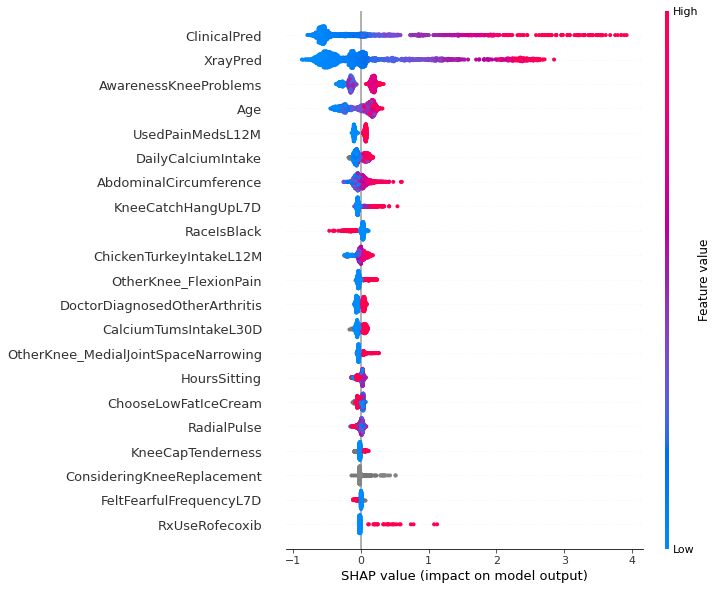

,Feature Id,LossFuncChgImportance,ShapImportance
0,ClinicalPred,0.037905,0.656666
1,XrayPred,0.022068,0.611131
2,ConsideringKneeReplacement,0.000929,0.015970
3,Age,0.000753,0.174483
4,OtherKnee_MedialJointSpaceNarrowing,0.000527,0.037523
5,OtherKnee_FlexionPain,0.000363,0.049002
6,AbdominalCircumference,0.000302,0.068050
7,DoctorDiagnosedOtherArthritis,0.000257,0.048304
8,RxUseRofecoxib,0.000252,0.014761
9,KneeCatchHangUpL7D,0.000232,0.062761


{'logloss': 0.1464, 'accuracy': 0.9506, 'balanced_accuracy': 0.6867, 'auroc': 0.9019, 'auprc': 0.5309}


In [30]:
# use selected features 
cb_preds, cb_model, cb_full_shap, cb_importances, cb_metrics = fit_eval_catboost(
    cat_features=[], 
    num_features=selected_features, 
    train_df=train, val_df=val,
    plot_training=False, plot_shap=True, display_importances=True)

In [31]:
# run cv on the selected features 
catboost_selected_cv_preds, _ = cv_catboost(cat_features=[], 
    num_features=selected_features,
    df=df, label='KR_LABEL', verbose=False, 
    learning_rate=None, iterations=None)
metrics_catboost_subset = get_eval_metrics(
    y_true=catboost_selected_cv_preds['KR_LABEL'], y_pred=catboost_selected_cv_preds['Probability'])
print(f"CV metrics: {metrics_catboost_subset}")

CV metrics: {'logloss': 0.1429, 'accuracy': 0.9527, 'balanced_accuracy': 0.6692, 'auroc': 0.9009, 'auprc': 0.5483}


# Select Best Model and Predict on Test Set

Based on our CV results (on train set), we choose logistic regression with `ClinicalPredLogit` and  `XrayPredLogit` as input features (Model 2) as our final model. We refit this model on the full train set and evaluate on the test set. 

In [32]:
# as reference also include standalone clinical and xray models 
cv_metrics = {
    'LogitWithPreds': metrics_logit,
    'LogitWithPredLogits': metrics_logit_logits,
    'CatBoostPredsOnly': metrics_catboost_simple,
    'CatBoostFullWithXrayPreds': metrics_catboost_full_with_xray,
    'CatBoostFullWithBothPreds': metrics_catboost_full_with_both, 
    'CatBoostSelectedWithPreds': metrics_catboost_subset,
    'ClinicalOnly': get_eval_metrics(y_true=df['KR_LABEL'], y_pred=logit_cv_preds['ClinicalPred']),
    'XrayOnly': get_eval_metrics(y_true=df['KR_LABEL'], y_pred=logit_cv_preds['XrayPred'])
}
pd.DataFrame(cv_metrics).T

,logloss,accuracy,balanced_accuracy,auroc,auprc
LogitWithPreds,0.1550,0.9459,0.6484,0.8944,0.5002
LogitWithPredLogits,0.1411,0.9535,0.6788,0.9011,0.5708
CatBoostPredsOnly,0.1443,0.9521,0.6757,0.8979,0.5445
CatBoostFullWithXrayPreds,0.1395,0.9524,0.6587,0.9091,0.5643
CatBoostFullWithBothPreds,0.1438,0.9524,0.6598,0.8989,0.5437
CatBoostSelectedWithPreds,0.1429,0.9527,0.6692,0.9009,0.5483
ClinicalOnly,0.1614,0.9431,0.5687,0.8777,0.4272
XrayOnly,0.1971,0.9361,0.5408,0.7865,0.2493


In [33]:
final_logit, final_preds, final_metrics = fit_eval_logit(
    cat_features=[], num_features=['ClinicalPredLogit', 'XrayPredLogit'],
    other_formula=None, train=df, val=test_df, label='KR_LABEL')
print(f"Final Model Test Metrics: {final_metrics}")

Optimization terminated successfully.
         Current function value: 0.136850
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               KR_LABEL   No. Observations:                 6695
Model:                          Logit   Df Residuals:                     6692
Method:                           MLE   Df Model:                            2
Date:                Mon, 13 Dec 2021   Pseudo R-squ.:                  0.4028
Time:                        02:46:05   Log-Likelihood:                -916.21
converged:                       True   LL-Null:                       -1534.1
Covariance Type:            nonrobust   LLR p-value:                4.549e-269
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4104      0.174     13.842      0.000       2.069       2.752
ClinicalPredLogit     1.1427      0.049     23.101      0.000       1.046       1.240
XrayPredLogit         0.7612      0.046     16.459      0.000       0.671       0.852
=====================================================================================
"""

{'logloss': 0.1575, 'accuracy': 0.9379, 'balanced_accuracy': 0.6712, 'auroc': 0.9056, 'auprc': 0.4691}
Final Model Test Metrics: {'logloss': 0.1575, 'accuracy': 0.9379, 'balanced_accuracy': 0.6712, 'auroc': 0.9056, 'auprc': 0.4691}


In [34]:
# compare test metrics of our final combined model with standalone xray and clinical models
full_test_metrics = {
    'CombinedModel': get_eval_metrics(y_true=final_preds['KR_LABEL'], y_pred=final_preds['Prediction']),
    'ClinicalOnly': get_eval_metrics(y_true=final_preds['KR_LABEL'], y_pred=final_preds['ClinicalPred']),
    'XrayOnly': get_eval_metrics(y_true=final_preds['KR_LABEL'], y_pred=final_preds['XrayPred'])
}
pd.DataFrame(full_test_metrics).T

,logloss,accuracy,balanced_accuracy,auroc,auprc
CombinedModel,0.1575,0.9379,0.6712,0.9056,0.4691
ClinicalOnly,0.1702,0.9405,0.5798,0.8747,0.3732
XrayOnly,0.2113,0.9414,0.5321,0.7946,0.2825


In [35]:
# output final predictions 
final_preds.to_csv(ENSEMBLE_TEST_PREDS_FP, index=False)